Gaussian Process Regression for Ship Tracking via AIS Data

Import required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, DotProduct, RBF, WhiteKernel

Import dataframe and print head

In [2]:
# Import dataframe
path_to_df = 'ais_dataset/unipi_ais_dynamic_jan2019.csv'
df = pd.read_csv(path_to_df)

print(df.head())

               t                                          vessel_id  \
0  1548701541000  29b2c240d3ee158281fb4ad556939ee938d08685bd796a...   
1  1548701542000  4370e27814614fc0a8e27e9289a7a9299dc8add830e993...   
2  1548701543000  5de00399a2fdba5f2eb761a622a79a73af9d4058d51e6b...   
3  1548701544000  7f080c68ffb5cbe042d98b2524fc8a56db5bb75315f106...   
4  1548701545000  0fe51bee65c87f2f06f33d5b42fd47dfaf7d99c72336e2...   

         lon        lat  heading  speed  course  
0  23.615058  37.944708      NaN    0.0   221.3  
1  23.554450  37.875880    141.0    0.3     6.4  
2  23.641648  37.944590      NaN    0.0   196.4  
3  23.641433  37.947900    179.0    0.0   103.0  
4  23.612498  37.897965    175.0   14.5   173.5  


Clean dataframe and select a single ship for 5 minutes

In [ ]:
# Column indexes
t_col = 0
vessel_id_col = 1
lon_col = 2
lat_col = 3
speed_col = 5

# Reorder dataframe in temporal ascending order and remove duplicate rows
df = df.sort_values(by = df.columns[t_col], ascending = True)
df = df.drop_duplicates(keep = 'first')

# Select id of first ship in dataframe with speed at least 7 m/s
ship_id = df.loc[df.iloc[:, speed_col] >= 7, 'vessel_id'].iloc[0]

# Consider only selected ship
df = df[df.iloc[:, vessel_id_col] == ship_id]

# Select observation time [s]
obersvation_time = 5 * 60

# Reference time [ms]
initial_reference_time = df.iloc[0, t_col]
final_reference_time = initial_reference_time + obersvation_time * 1000

# Consider dataframe of single ship for the whole observation duration
df = df[df.iloc[:, t_col] <= final_reference_time]

print(df.head())

Save and plot latitude and longitude over time

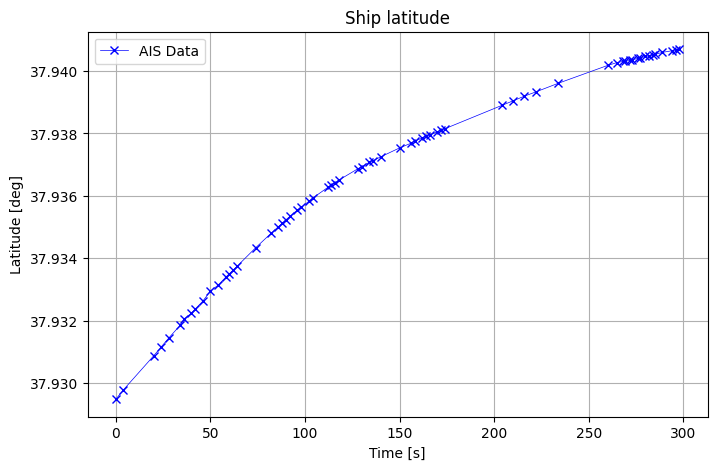

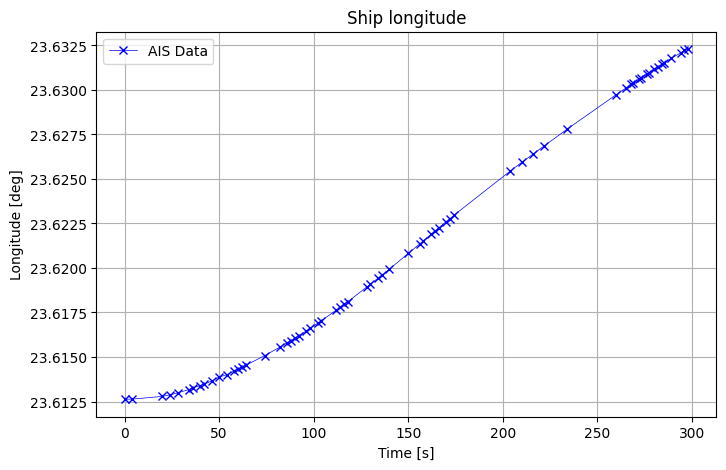

In [4]:
# Initialize arrays
time, lon, lat = np.zeros(df.shape[0]), np.zeros(df.shape[0]), np.zeros(df.shape[0])

# Save data
for r in range(df.shape[0]):
    # Save longitude and latitude
    lon[r] = df.iloc[r, lon_col]
    lat[r] = df.iloc[r, lat_col]

    # Shift back and convert time in seconds
    time[r] = (df.iloc[r, t_col] - initial_reference_time) / 1000

# Plot latitude
plt.figure(figsize=(8, 5))
plt.plot(time, lat, color="b", marker = 'x', linewidth=.5, label = 'AIS Data')
plt.xlabel("Time [s]")
plt.ylabel("Latitude [deg]")
plt.title("Ship latitude")
plt.grid(True)
plt.legend()
plt.show()

# Plot longitude
plt.figure(figsize=(8, 5))
plt.plot(time, lon, color="b", marker = 'x', linewidth=.5, label = 'AIS Data')
plt.xlabel("Time [s]")
plt.ylabel("Longitude [deg]")
plt.title("Ship longitude")
plt.grid(True)
plt.legend()
plt.show()

Create training set

In [5]:
# Select number of trainin set
number_train_data = round(df.shape[0] / 6)

# Create training set
train_set_indexes = np.random.choice(len(time), number_train_data, replace=False) 
time_train = time[train_set_indexes]
lon_train = lon[train_set_indexes]
lat_train = lat[train_set_indexes]

# Create time indexes for testing
test_set_indexes = np.setdiff1d(np.arange(len(time)), train_set_indexes)
time_test = time[test_set_indexes]

Train a GPR and plot output

/home/matteo/Desktop/gpr_course_exam/codes/csar_paper_venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/matteo/Desktop/gpr_course_exam/codes/csar_paper_venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


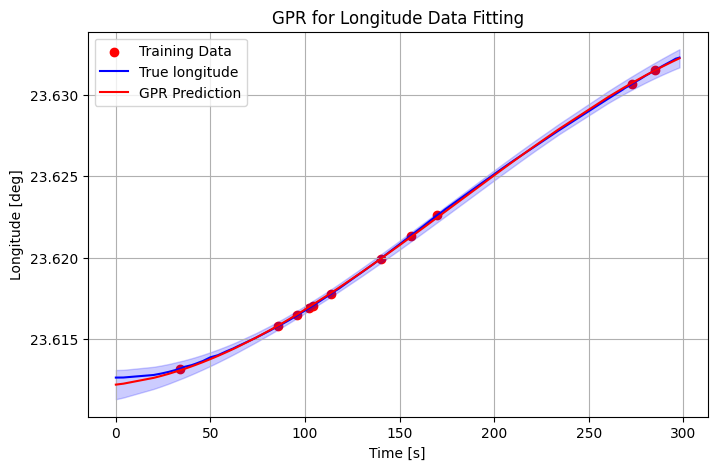

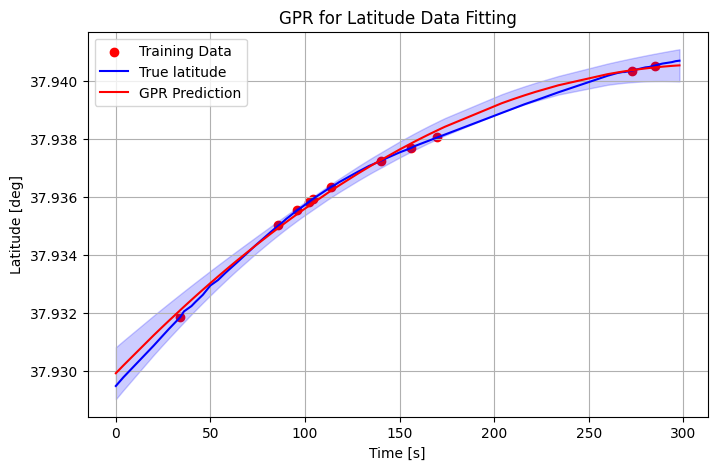

In [ ]:
# Define kernels
kernel_lon = DotProduct() + RBF(length_scale=1.0)
kernel_lat = DotProduct() + RBF(length_scale=1.0)

# Train GPR on longitude
gpr_lon = GaussianProcessRegressor(kernel=kernel_lon, alpha = 1e-7, n_restarts_optimizer=20) # alpha=1.0 assumes some noise
gpr_lon.fit(time_train.reshape(-1, 1), lon_train)

# Train GPR on latitude
gpr_lat = GaussianProcessRegressor(kernel=kernel_lat, alpha = 1e-7, n_restarts_optimizer=20) # alpha=1.0 assumes some noise
gpr_lat.fit(time_train.reshape(-1, 1), lat_train)

# Predict longitude on test set
lon_pred, sigma = gpr_lon.predict(time_test.reshape(-1, 1), return_std=True)

# Predict latitude on test set
lat_pred, sigma = gpr_lat.predict(time_test.reshape(-1, 1), return_std=True)

# Plot longitude regression results
plt.figure(figsize=(8, 5))
# Training data
plt.scatter(time_train, lon_train, color='red', label="Training Data")
# Real trajectory
plt.plot(time, lon, color = 'blue', label = 'True longitude')
# GPR prediction
plt.plot(time_test, lon_pred, color='red',label="GPR Prediction")
plt.fill_between(time_test.ravel(), lon_pred - 2 * sigma, lon_pred + 2 * sigma, alpha=0.2, color='blue', label = )
plt.xlabel("Time [s]")
plt.ylabel("Longitude [deg]")
plt.title("GPR for Longitude Data Fitting")
plt.grid()
plt.legend()
plt.show()

# Plot latitude results
plt.figure(figsize=(8, 5))
# Training data
plt.scatter(time_train, lat_train, color='red', label="Training Data")
# Real trajectory
plt.plot(time, lat, color = 'blue', label = 'True latitude')
# GPR prediction
plt.plot(time_test, lat_pred, color='red',label="GPR Prediction")
plt.fill_between(time_test.ravel(), lat_pred - 2 * sigma, lat_pred + 2 * sigma, alpha=0.2, color='blue')
plt.xlabel("Time [s]")
plt.ylabel("Latitude [deg]")
plt.title("GPR for Latitude Data Fitting")
plt.grid()
plt.legend()
plt.show()